In [1]:
# Importing the relevant libraries
import IPython.display
import json
import pandas as pd
import seaborn as sns
import squarify
%matplotlib inline
import random
#import missingno as msno
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls
import numpy as np
from matplotlib import pyplot as plt

# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template# The data to load


In [2]:
%%time

f = "../Data/train.csv"

# Count the lines
num_lines = sum(1 for l in open(f))

# Sample size - in this case ~10%
size = int(num_lines / 20)

# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx = random.sample(range(1, num_lines), num_lines - size)

# Read the data
train = pd.read_csv(f, skiprows=skip_idx, parse_dates=['date'] )

<string>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 5min 49s


In [3]:
%%time
## For now, only loading 10,000,000 rows to speed up import
# nrows=10000000

items = pd.read_csv("../Data/items.csv")
holiday_events = pd.read_csv("../Data/holidays_events.csv")
stores = pd.read_csv("../Data/stores.csv")
oil = pd.read_csv("../Data/oil.csv",parse_dates=['date'])
transactions = pd.read_csv("../Data/transactions.csv",parse_dates=['date'])
# Read in the full training data just to get prior information and here is the output:
# Output: "125,497,040 rows | 6 columns"
#train = pd.read_csv("../Data/train.csv", parse_dates=['date'])

Wall time: 172 ms


# Inspecting train.csv

In [4]:
# Visually inspect train.csv data
train.head()

## See that onpromotion contains many NaN values
## NaN probably means No
## Data appears tidy
    # 1) Columns represent separate variables
    # 2) Rows represent individual observations
    # 3) Observational units form tables
    


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,23,2013-01-01,25,119624,4.0,NaN
1,37,2013-01-01,25,164036,1.0,NaN
2,42,2013-01-01,25,165594,4.0,NaN
3,98,2013-01-01,25,273528,2.0,NaN
4,127,2013-01-01,25,315474,5.0,NaN


In [11]:
## Cleaned up the NaN values by replacing with False
##train['onpromotion'].fillna(False, inplace=True)

In [5]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,23,2013-01-01,25,119624,4.0,NaN
1,37,2013-01-01,25,164036,1.0,NaN
2,42,2013-01-01,25,165594,4.0,NaN
3,98,2013-01-01,25,273528,2.0,NaN
4,127,2013-01-01,25,315474,5.0,NaN


In [6]:
train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
6274846,125496951,2017-08-15,54,2013309,1.0,False
6274847,125496963,2017-08-15,54,2026444,7.0,False
6274848,125496965,2017-08-15,54,2026501,2.0,False
6274849,125496968,2017-08-15,54,2026945,3.0,False
6274850,125496981,2017-08-15,54,2042941,10.0,False


In [7]:
# Check for null values in train
# Borrowed technique from Anisotropic: 
#https://www.kaggle.com/arthurtok/comprehensive-python-and-d3-js-favorita-analytics
print("Nulls in train columns: {0} => {1}".format(train.columns.values, train.isnull().any().values))

Nulls in train columns: ['id' 'date' 'store_nbr' 'item_nbr' 'unit_sales' 'onpromotion'] => [False False False False False  True]


In [8]:
train.set_index('date', inplace=True)

In [9]:
train.info()
## no count of non-null values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6274851 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
id             int64
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    object
dtypes: float64(1), int64(3), object(1)
memory usage: 287.2+ MB


In [10]:
train.describe()
## Summary stats not really meaningful in this context

,id,store_nbr,item_nbr,unit_sales
count,6.274851e+06,6.274851e+06,6.274851e+06,6.274851e+06
mean,6.274537e+07,2.747499e+01,9.728528e+05,8.550664e+00
std,3.622711e+07,1.633191e+01,5.205036e+05,2.069400e+01
min,2.300000e+01,1.000000e+00,9.699500e+04,-4.480000e+02
25%,3.137581e+07,1.200000e+01,5.227210e+05,2.000000e+00
50%,6.275216e+07,2.800000e+01,9.594370e+05,4.000000e+00
75%,9.411146e+07,4.300000e+01,1.354380e+06,9.000000e+00
max,1.254970e+08,5.400000e+01,2.127114e+06,7.759000e+03


In [11]:
print(train.shape)
## Train contains 10 million rows (as expected),  but only 6 columns

(6274851, 5)


In [12]:
train['test'] = 1

In [13]:
train.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,test
date,,,,,,
2013-01-01,23,25,119624,4.0,NaN,1
2013-01-01,37,25,164036,1.0,NaN,1
2013-01-01,42,25,165594,4.0,NaN,1
2013-01-01,98,25,273528,2.0,NaN,1
2013-01-01,127,25,315474,5.0,NaN,1


In [14]:
test_df = train.test.resample('D').sum()

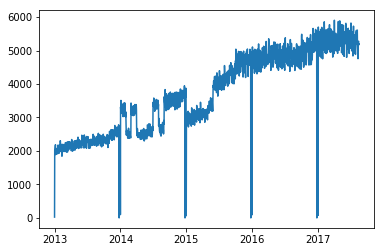

In [15]:
plt.plot(test_df)

Looks like the unique SKUs sold each day has been increasing. There was a dip near the end of 2014 but a big increase in mid-2015. Looks like the stores close around the end of the year (probably Christmas)

In [28]:
promo_df = pd.pivot_table(data=train, index='onpromotion', values='test', aggfunc='count', dropna=False)
promo_df.head()

,test
onpromotion,
False,4800958
True,389950


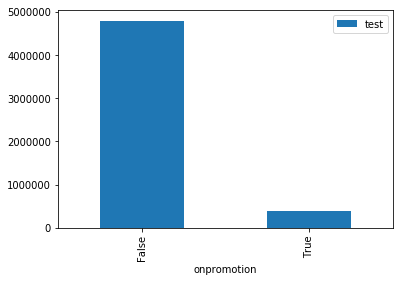

In [36]:
promo_df.plot(kind='bar')

In [37]:
pos_unit_sales_df = train[train['unit_sales'] >= 0]

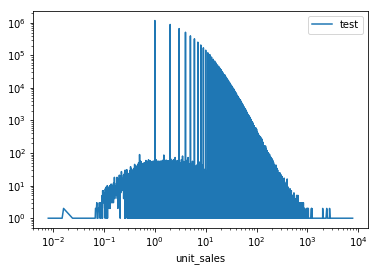

In [39]:
pd.pivot_table(data=pos_unit_sales_df, index='unit_sales', values='test', aggfunc='count').plot(loglog=True)

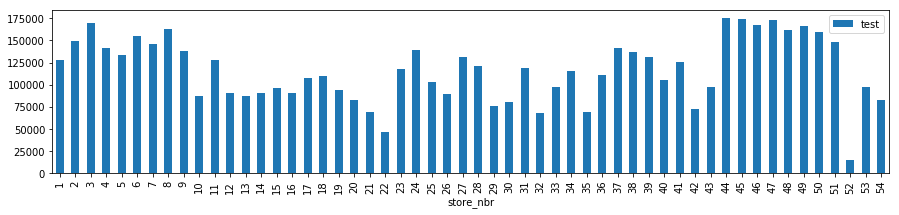

In [43]:
pd.pivot_table(data=train, index='store_nbr', values='test', aggfunc='count').plot(kind='bar', figsize=(15, 3))

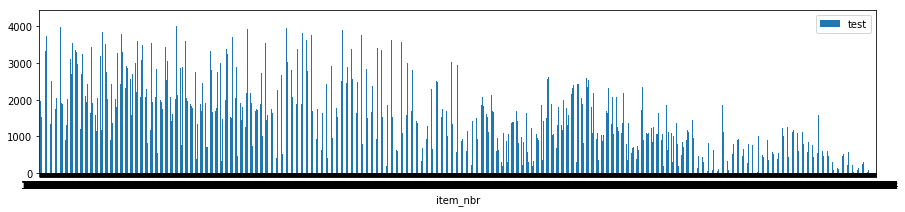

In [46]:
pd.pivot_table(data=train, index='item_nbr', values='test', aggfunc='count').plot(kind='bar', figsize=(15,3), xticks=[])

In [48]:
neg_unit_sales_df = train[train['unit_sales'] < 0]

In [60]:
neg_unit_sales_df['unit_sales'] = abs(neg_unit_sales_df['unit_sales']).values


C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
neg_unit_sales_df.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,test
date,,,,,,
2013-01-11,382905,27,1097187,20.0,NaN,1
2013-01-23,870159,28,172995,1.0,NaN,1
2013-02-05,1389352,5,660502,3.0,NaN,1
2013-02-14,1777403,35,414752,1.0,NaN,1
2013-02-19,1964033,4,321798,1.0,NaN,1


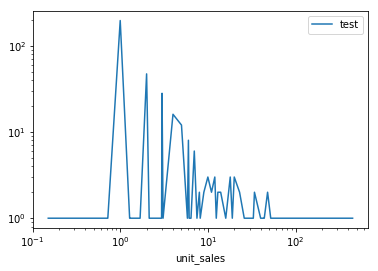

In [73]:
pd.pivot_table(data=neg_unit_sales_df, index='unit_sales', values='test', aggfunc='count').plot(loglog=True)

In [25]:
# drop duplicates
train_no_duplicates = train.drop_duplicates()

In [26]:
train_no_duplicates.info()
# no duplicates were detected

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6274851 entries, 2013-01-01 to 2017-08-15
Data columns (total 6 columns):
id             int64
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    bool
test           int64
dtypes: bool(1), float64(1), int64(4)
memory usage: 293.2 MB


In [67]:
print(outliers)

                id  store_nbr  item_nbr  unit_sales  onpromotion  test
date                                                                  
2013-01-08  276274         44    510054    4021.000        False     1
2013-01-15  542175         23    583985    5219.785        False     1
2013-01-22  840542         44    510054    4015.000        False     1


In [4]:
PN510054 = train[train["item_nbr"] == 510054]
PN510054.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
222,222,2013-01-01,25,510054,7.0,False
987,987,2013-01-02,1,510054,31.0,False
2029,2029,2013-01-02,2,510054,30.0,False
3164,3164,2013-01-02,3,510054,52.0,False
4326,4326,2013-01-02,4,510054,9.0,False


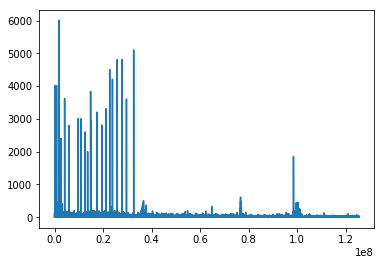

In [5]:
PN510054['unit_sales'].plot()

# Inspecting oil.csv


In [24]:
# Set the date column to be index
oil.set_index('date', inplace=True)

In [25]:
oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [27]:
print(oil[oil['dcoilwtico'].isnull()].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43 entries, 2013-01-01 to 2017-07-04
Data columns (total 1 columns):
dcoilwtico    0 non-null float64
dtypes: float64(1)
memory usage: 688.0 bytes
None


In [28]:
oil.tail()
# immediately see that oil hald as expensive in 2017 than in 2013

,dcoilwtico
date,
2017-08-25,47.65
2017-08-28,46.40
2017-08-29,46.46
2017-08-30,45.96
2017-08-31,47.26


In [29]:
oil.info()
# missing oil data in about 43 rows
# date column is object type, not datetime

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 1 columns):
dcoilwtico    1175 non-null float64
dtypes: float64(1)
memory usage: 19.0 KB


In [30]:
print("Nulls in oil columns: {0} => {1}".format(oil.columns.values, oil.isnull().any().values))

Nulls in oil columns: ['dcoilwtico'] => [ True]


In [31]:
# Replace NaN values using backward fill to cover first date 
oil['dcoilwtico'].fillna(method='bfill', inplace=True)

In [32]:
# No more NaN values
print(oil[oil['dcoilwtico'].isnull()])

Empty DataFrame
Columns: [dcoilwtico]
Index: []


In [33]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 1 columns):
dcoilwtico    1218 non-null float64
dtypes: float64(1)
memory usage: 19.0 KB


In [34]:
print(oil.shape)

(1218, 1)


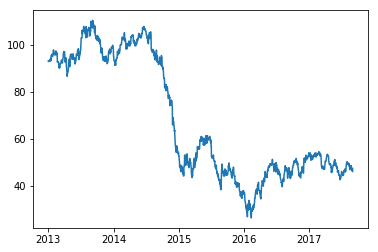

In [35]:
plt.plot(oil)
plt.show()

It appears the price of oil hovered around 100 dollar until late 2014 when it dropped suddenly to the 50 dollar range. 

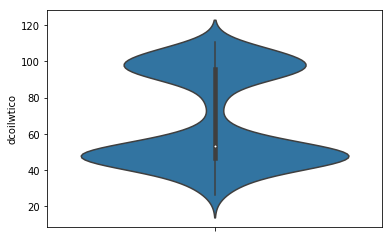

In [37]:
_ = sns.violinplot(y="dcoilwtico", data=oil)

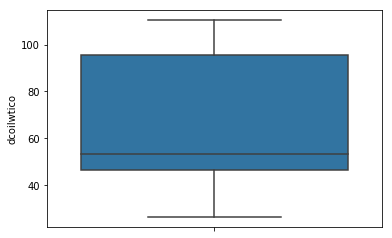

In [38]:
_ = sns.boxplot(y="dcoilwtico", data=oil)

# Inspecting stores.csv

In [30]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [44]:
stores['n'] = 1

In [43]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 6 columns):
store_nbr    54 non-null int64
city         54 non-null object
state        54 non-null object
type         54 non-null object
cluster      54 non-null int64
n            54 non-null int64
dtypes: int64(3), object(3)
memory usage: 2.6+ KB


In [32]:
print("Nulls in stores columns: {0} => {1}".format(stores.columns.values, stores.isnull().any().values))

Nulls in stores columns: ['store_nbr' 'city' 'state' 'type' 'cluster'] => [False False False False False]


In [33]:
stores['city'].unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [34]:
stores['state'].unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [35]:
stores['store_nbr'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54], dtype=int64)

In [36]:
stores['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [37]:
stores['cluster'].unique()

array([13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17],
      dtype=int64)

Looks like there are 54 stores spread across 17 clusters in 16 different states in Ecuador.

In [55]:
cluster_tbl = pd.pivot_table(stores, index='cluster', values='store_nbr', aggfunc='count')

In [56]:
print(cluster_tbl)

         store_nbr
cluster           
1                3
2                2
3                7
4                3
5                1
6                6
7                2
8                3
9                2
10               6
11               3
12               1
13               4
14               4
15               5
16               1
17               1


In [65]:
city_tbl = pd.pivot_table(stores, index='city', values='store_nbr', aggfunc='count').sort_values('store_nbr', ascending=False)
print(city_tbl)

               store_nbr
city                    
Quito                 18
Guayaquil              8
Santo Domingo          3
Cuenca                 3
Manta                  2
Machala                2
Latacunga              2
Ambato                 2
Guaranda               1
Ibarra                 1
Esmeraldas             1
Babahoyo               1
Loja                   1
El Carmen              1
Daule                  1
Playas                 1
Puyo                   1
Quevedo                1
Cayambe                1
Riobamba               1
Salinas                1
Libertad               1


Most stores are in Quito and Guayaquil

# Inspecting items.csv

In [33]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [34]:
items.tail()

,item_nbr,family,class,perishable
4095,2132318,GROCERY I,1002,0
4096,2132945,GROCERY I,1026,0
4097,2132957,GROCERY I,1068,0
4098,2134058,BEVERAGES,1124,0
4099,2134244,"LIQUOR,WINE,BEER",1364,0


In [119]:
print("Nulls in items columns: {0} => {1}".format(items.columns.values, items.isnull().any().values))

Nulls in items columns: ['item_nbr' 'family' 'class' 'perishable'] => [False False False False]


In [97]:
print(pd.pivot_table(items, index='family', values='item_nbr', aggfunc='count').sort_values('item_nbr', ascending=False))

                            item_nbr
family                              
GROCERY I                       1334
BEVERAGES                        613
CLEANING                         446
PRODUCE                          306
DAIRY                            242
PERSONAL CARE                    153
BREAD/BAKERY                     134
HOME CARE                        108
DELI                              91
MEATS                             84
HOME AND KITCHEN I                77
LIQUOR,WINE,BEER                  73
FROZEN FOODS                      55
POULTRY                           54
HOME AND KITCHEN II               45
EGGS                              41
CELEBRATION                       31
PREPARED FOODS                    26
LAWN AND GARDEN                   26
LADIESWEAR                        21
LINGERIE                          20
AUTOMOTIVE                        20
BEAUTY                            19
PLAYERS AND ELECTRONICS           17
SCHOOL AND OFFICE SUPPLIES        15
P

In [120]:
print(pd.pivot_table(items, index='class', values='item_nbr', aggfunc='count').sort_values('item_nbr', ascending=False).head())

       item_nbr
class          
1016        133
1040        110
1124        100
1034         98
1122         81


In [100]:
## All perishable items
perishables = items[items['perishable'] > 0.0]

In [121]:
## Perishable foods appear to be deli, bread, poulty, dairy items
perishables.head()

,item_nbr,family,class,perishable
4,103665,BREAD/BAKERY,2712,1
15,108696,DELI,2636,1
16,108698,DELI,2644,1
17,108701,DELI,2644,1
20,108831,POULTRY,2416,1


In [35]:
items.info()
## no null values in any column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
item_nbr      4100 non-null int64
family        4100 non-null object
class         4100 non-null int64
perishable    4100 non-null int64
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


In [36]:
items.describe()

,item_nbr,class,perishable
count,4.100000e+03,4100.0000,4100.000000
mean,1.251436e+06,2169.6500,0.240488
std,5.876872e+05,1484.9109,0.427432
min,9.699500e+04,1002.0000,0.000000
25%,8.181108e+05,1068.0000,0.000000
50%,1.306198e+06,2004.0000,0.000000
75%,1.904918e+06,2990.5000,0.000000
max,2.134244e+06,7780.0000,1.000000


# Inspecting holiday_events.csv

In [71]:
holiday_events.set_index('date', inplace=True)

In [72]:
holiday_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [73]:
holiday_events.tail()

,type,locale,locale_name,description,transferred
date,,,,,
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False
2017-12-25,Holiday,National,Ecuador,Navidad,False
2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [122]:
print("Nulls in holiday_events columns: {0} => {1}".format(holiday_events.columns.values, holiday_events.isnull().any().values))

Nulls in holiday_events columns: ['type' 'locale' 'locale_name' 'description' 'transferred' 'n'] => [False False False False False False]


In [74]:
holiday_events.describe()

,type,locale,locale_name,description,transferred
count,350,350,350,350,350
unique,6,3,24,103,2
top,Holiday,National,Ecuador,Carnaval,False
freq,221,174,174,10,338


In [75]:
holiday_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 2012-03-02 to 2017-12-26
Data columns (total 5 columns):
type           350 non-null object
locale         350 non-null object
locale_name    350 non-null object
description    350 non-null object
transferred    350 non-null bool
dtypes: bool(1), object(4)
memory usage: 14.0+ KB


In [76]:
holiday_events['n'] = 1

In [77]:
holiday_events.head()

,type,locale,locale_name,description,transferred,n
date,,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1


In [79]:
holiday_events_piv = pd.pivot_table(holiday_events, index='date', values='n', aggfunc='sum')

In [86]:
print(holiday_events['type'].unique())

['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']


In [87]:
print(pd.pivot_table(holiday_events, index='type', values='n', aggfunc='sum'))

              n
type           
Additional   51
Bridge        5
Event        56
Holiday     221
Transfer     12
Work Day      5


In [88]:
print(pd.pivot_table(holiday_events, index='locale', values='n', aggfunc='sum'))

            n
locale       
Local     152
National  174
Regional   24


In [95]:
holiday_locs = pd.pivot_table(holiday_events, index='locale_name', values='n', aggfunc='sum')
print(holiday_locs.sort_values('n', ascending=False))

                                  n
locale_name                        
Ecuador                         174
Quito                            13
Ambato                           12
Guaranda                         12
Riobamba                         12
Latacunga                        12
Guayaquil                        11
Cuenca                            7
Ibarra                            7
Manta                             6
Santo Domingo                     6
Santa Elena                       6
Salinas                           6
Quevedo                           6
Puyo                              6
Libertad                          6
Machala                           6
Loja                              6
Cayambe                           6
Imbabura                          6
Esmeraldas                        6
El Carmen                         6
Cotopaxi                          6
Santo Domingo de los Tsachilas    6


# Inspecting transactions.csv

In [102]:
## Looks like transactions contains the number of unique transactions per store per day
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [103]:
transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [104]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
date            83488 non-null datetime64[ns]
store_nbr       83488 non-null int64
transactions    83488 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [105]:
transactions.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


In [123]:
print("Nulls in transactions columns: {0} => {1}".format(transactions.columns.values, transactions.isnull().any().values))

Nulls in transactions columns: ['date' 'store_nbr' 'transactions'] => [False False False]


In [106]:
daily_trans = pd.pivot_table(transactions, index='date', values='transactions', aggfunc='sum')

In [107]:
print(daily_trans.head())

            transactions
date                    
2013-01-01           770
2013-01-02         93215
2013-01-03         78504
2013-01-04         78494
2013-01-05         93573


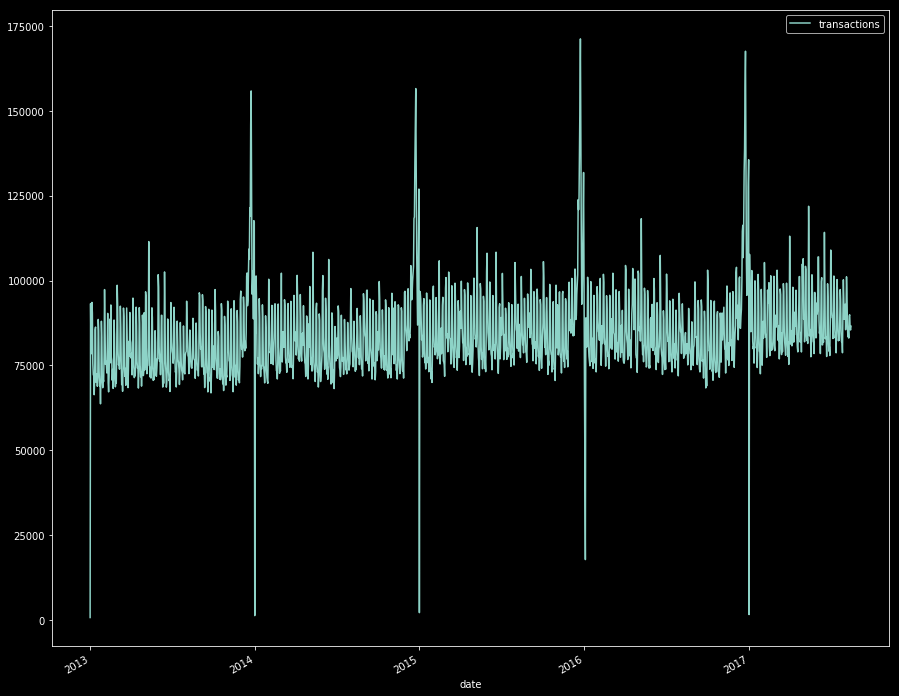

In [109]:
## Appears to be steady upward trend over time. 
## See huge peaks around Christmas season, followed by huge dips, probably holiday closures
daily_trans.plot(figsize=(15,13))